In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from boltzmann_machines.RTRBM_no_bias import RTRBM_nobias
from boltzmann_machines.RTRBM import RTRBM

In [2]:
N_V = 100
T = 100
n_batches = 500
hidden_visible_ratio = .1 # should be .005

N_H = int(hidden_visible_ratio*N_V)
data = torch.zeros(N_V, T, n_batches)

pre_defined_sparse_rtrbm = RTRBM(data, N_H=N_H, device='cpu')

Text(403.4117647058824, 0.5, 'amount')

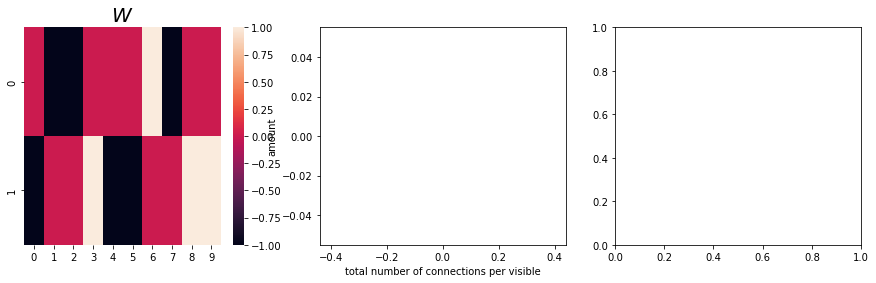

In [4]:
W = torch.zeros(N_H, N_V)
for V in range(N_V):
    n_conn = torch.poisson(torch.ones(1))

    hidden_conn = torch.randint(low=0, high=N_H, size=(int(n_conn), 1))
    while torch.sum(hidden_conn == hidden_conn.T) > n_conn:
        hidden_conn = torch.randint(low=0, high=N_H, size=(int(n_conn), 1))

    x = torch.rand(1)
    if x > .5:
        W[hidden_conn, V] = 1
    else:
        W[hidden_conn, V] = -1

max_number_of_conn = int(torch.max(torch.sum(torch.abs(W), 0)))
tmp = torch.zeros(max_number_of_conn)
for i in range(max_number_of_conn):
    tmp[i] = torch.sum(torch.sum(torch.abs(W), 0) == i)

fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.heatmap(W, ax=axes[0])
axes[0].set_title('$W$', fontsize=20)
axes[1].bar(torch.arange(max_number_of_conn), tmp)
axes[1].set_xlabel('total number of connections per visible')
axes[1].set_ylabel('amount')


Find a balanced network

tensor(0.9217)
tensor(0.5090)


Text(0.5, 1.0, '$r^{[t]}$')

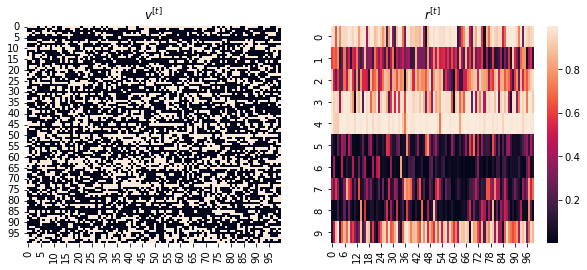

In [28]:
from tqdm import tqdm
b_init = torch.zeros(1, N_H, dtype=torch.float)
b_V = torch.zeros(1, N_V, dtype=torch.float)
b_H = torch.zeros(1, N_H, dtype=torch.float)

pre_defined_sparse_rtrbm.W = W
pre_defined_sparse_rtrbm.W_acc = torch.randn(N_H, N_H)
pre_defined_sparse_rtrbm.b_V = -.5 * torch.ones(1, N_V)
pre_defined_sparse_rtrbm.b_H = torch.randn(1, N_H) + torch.randn(1)
pre_defined_sparse_rtrbm.b_init = torch.randn(1, N_H) + torch.randn(1)
v_start = (torch.rand(N_V) > 0.2)*1.0
data, rt = pre_defined_sparse_rtrbm.sample(v_start.type(torch.float), chain=T, pre_gibbs_k=100, gibbs_k=100, mode=1, disable_tqdm=True)
print(torch.mean(rt))
while torch.mean(rt) < .2 or torch.mean(rt) > .8:
    pre_defined_sparse_rtrbm.W_acc = torch.randn(N_H, N_H)
    pre_defined_sparse_rtrbm.b_H = torch.randn(1, N_H) + torch.randn(1)
    pre_defined_sparse_rtrbm.b_init = torch.randn(1, N_H) + torch.randn(1)
    v_start = (torch.rand(N_V) > 0.2)*1.0
    data, rt = pre_defined_sparse_rtrbm.sample(v_start.type(torch.float), chain=T, pre_gibbs_k=100, gibbs_k=100, mode=1, disable_tqdm=True)
    print(torch.mean(rt))

fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.heatmap(data, ax=axes[0], cbar=False)
axes[0].set_title('$v^{[t]}$')
sns.heatmap(rt, ax=axes[1])
axes[1].set_title('$r^{[t]}$')

Can the RTRBM train on this? (with bias -aid)

In [29]:
n_batches = 300
data = torch.zeros(N_V, T, n_batches)
rt = torch.zeros(N_H, T, n_batches)
for batch in tqdm(range(n_batches)):
    v_start = (torch.rand(N_V) > 0.2)*1.0
    data[:, :, batch], rt[:, :, batch] = pre_defined_sparse_rtrbm.sample(v_start.type(torch.float), chain=T, pre_gibbs_k=0, gibbs_k=20, mode=1, disable_tqdm=True)

100%|██████████| 300/300 [01:17<00:00,  3.89it/s]


In [21]:
list = []

for  in [1, 2]:
    for sp in [3e-5, 1e-2, 3e-2, 7e-2, 1e-1]:
        rtrbm = RTRBM(data, N_H=N_H, device='cuda')
        rtrbm.b_V = -.5 * torch.ones(1, N_V, device='cuda')
        rtrbm.W = torch.zeros(N_H, N_V)
        rtrbm.b_H = pre_defined_sparse_rtrbm.b_H.to('cuda')
        rtrbm.b_init = pre_defined_sparse_rtrbm.b_init.to('cuda')
        rtrbm.learn(n_epochs=1000, lr=1e-4, batchsize=100, CDk=10, mom=.9, wc=.05

        list += [rtrbm]

100%|██████████| 200/200 [40:23<00:00, 12.12s/it]


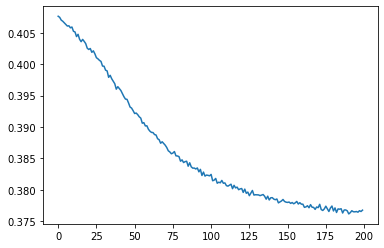

In [22]:
plt.plot(rtrbm.errors)

<AxesSubplot:>

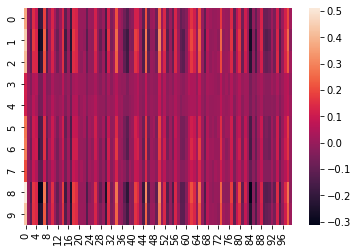

In [24]:
sns.heatmap(rtrbm.W.cpu())

In [25]:
rtrbm.learn(n_epochs=200, lr=1e-4, batchsize=100, CDk=10, mom=0, wc=0)

100%|██████████| 200/200 [41:18<00:00, 12.39s/it]


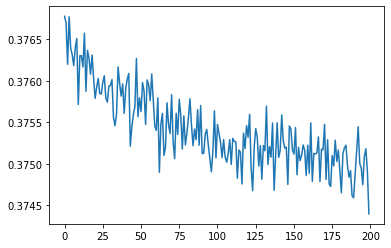

In [26]:
plt.plot(rtrbm.errors)

<AxesSubplot:>

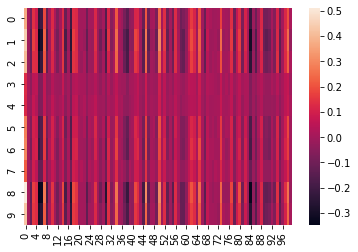

In [27]:
sns.heatmap(rtrbm.W.cpu())